## Модель близости транзакции к терминалу

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from typing import Tuple, Callable
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from catboost import CatBoostClassifier, Pool, cv

%matplotlib inline

In [2]:
data_path = 'terminals_geo'

train_df = pd.read_csv(os.path.join(data_path, 'train_points.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test_points_hidden.csv'))
txn_df = pd.read_csv(os.path.join(data_path, 'point_transactions.csv'))

In [3]:
# координаты Москвы
moscow_lat = 55.451332
moscow_lon = 37.369336

# границы РФ
lat_min, lat_max, lon_min, lon_max = 41.1850968, 82.0586232, 19.6389, 170

### Координаты за пределами России

In [4]:
init_txn_cnt = txn_df.shape[0]
txn_df = txn_df.drop(
    txn_df[
        ~txn_df.LAT.between(lat_min, lat_max) | ~txn_df.LON.between(lon_min, lon_max)
    ].index
)

In [5]:
print(f'осталось {txn_df.shape[0]/init_txn_cnt:.1%} транзакций')

осталось 85.5% транзакций


### Классификация

**Таргет**: лежит ли транзакция в малой окрестности терминала?

In [6]:
data = pd.merge(txn_df, train_df, 
                on='ID_MERCH', how='left', suffixes=('', '0')).dropna()

# расстояние между терминалом и транзакцией в градусах
data['r'] = np.sqrt((data.LAT-data.LAT0)**2 + (data.LON-data.LON0)**2)

# лежит ли транзакция в малой окрестности терминала
data['close'] = (data.r < 0.005).astype(float)

# замечены ли коордианты транзакции в нескольких терминалах
shared_df = txn_df.groupby(['LON', 'LAT']).apply(
    lambda x: x.ID_MERCH.nunique() > 1
).astype(int).to_frame('shared').reset_index()
data = pd.merge(data, shared_df, 
                on=['LON', 'LAT'], how='left', suffixes=('', ''))

# "задержка" между получением координат и транзакцией
data['delay'] = (
    pd.to_timedelta(data.RECORD_TIME).dt.total_seconds() 
    - pd.to_timedelta(data.TRANSACTION_TIME).dt.total_seconds()
)
data['abs_delay'] = np.abs(data.delay)

In [7]:
def add_location_features(df):
    locs = pd.read_csv('locations.csv')

    nearest_loc = NearestNeighbors(n_neighbors=2, radius=1.0)
    nearest_loc.fit(locs[['LON', 'LAT']].values)

    dists, neighs = nearest_loc.kneighbors(df[['LON', 'LAT']].values, n_neighbors=1, return_distance=True)

    df['neigh_loc'] = neighs.reshape(-1)
    df['neigh_dist'] = dists.reshape(-1)
    df['neigh_dx'] = locs.iloc[df.neigh_loc].LON.values - df.LON.values
    df['neigh_dy'] = locs.iloc[df.neigh_loc].LAT.values - df.LAT.values
    df['neigh_size'] = locs.iloc[df.neigh_loc]['size'].values

    df['neigh_type'] = 'tiny'
    df.loc[df['neigh_size'] > 5, 'neigh_type'] = 'small'
    df.loc[df['neigh_size'] > 10, 'neigh_type'] = 'avg'
    df.loc[df['neigh_size'] > 20, 'neigh_type'] = 'big'
    df.loc[df['neigh_size'] > 50, 'neigh_type'] = 'biggest'

    df['neigh_dy'] = df.neigh_dy.round(4)
    df['neigh_dx'] = df.neigh_dx.round(4)
    df['neigh_dist'] = df.neigh_dist.round(4)

In [8]:
add_location_features(data)

In [10]:
features = ['delay', 'abs_delay', 'shared', 'neigh_dist', 'neigh_dx', 'neigh_dy', 'neigh_type']

cat_features = ['shared', 'neigh_type']

In [11]:
balanced_data = pd.concat([
    data[data.close==1.0], 
    data[data.close==0].sample(int(data.close.sum()), random_state=0)
], axis=0).sample(frac=1.0)

In [12]:
val_data = balanced_data.sample(frac=0.15, random_state=0)
train_data = balanced_data[~balanced_data.index.isin(val_data.index)]

val_pool = Pool(
    data=val_data[features],
    label=val_data['close'],
    cat_features=[features.index(cf) for cf in cat_features]
)

train_pool = Pool(
    data=train_data[features],
    label=train_data['close'],
    cat_features=[features.index(cf) for cf in cat_features]
)

In [13]:
model = CatBoostClassifier(iterations=5000, verbose=False, 
                           random_state=0, early_stopping_rounds=100, use_best_model=True)

model.fit(train_pool, eval_set=val_pool, verbose=True)

Learning rate set to 0.033099
0:	learn: 0.6843736	test: 0.6840499	best: 0.6840499 (0)	total: 63.9ms	remaining: 5m 19s
1:	learn: 0.6730074	test: 0.6723244	best: 0.6723244 (1)	total: 82.1ms	remaining: 3m 25s
2:	learn: 0.6649080	test: 0.6641109	best: 0.6641109 (2)	total: 98.9ms	remaining: 2m 44s
3:	learn: 0.6585488	test: 0.6573717	best: 0.6573717 (3)	total: 108ms	remaining: 2m 14s
4:	learn: 0.6510862	test: 0.6496178	best: 0.6496178 (4)	total: 125ms	remaining: 2m 5s
5:	learn: 0.6425746	test: 0.6408686	best: 0.6408686 (5)	total: 144ms	remaining: 2m
6:	learn: 0.6366509	test: 0.6345720	best: 0.6345720 (6)	total: 157ms	remaining: 1m 52s
7:	learn: 0.6320612	test: 0.6297462	best: 0.6297462 (7)	total: 169ms	remaining: 1m 45s
8:	learn: 0.6266122	test: 0.6240363	best: 0.6240363 (8)	total: 185ms	remaining: 1m 42s
9:	learn: 0.6210812	test: 0.6184430	best: 0.6184430 (9)	total: 207ms	remaining: 1m 43s
10:	learn: 0.6168989	test: 0.6140972	best: 0.6140972 (10)	total: 228ms	remaining: 1m 43s
11:	learn: 0.

93:	learn: 0.5310339	test: 0.5290434	best: 0.5290434 (93)	total: 1.87s	remaining: 1m 37s
94:	learn: 0.5306900	test: 0.5289193	best: 0.5289193 (94)	total: 1.91s	remaining: 1m 38s
95:	learn: 0.5301483	test: 0.5285696	best: 0.5285696 (95)	total: 1.97s	remaining: 1m 40s
96:	learn: 0.5300125	test: 0.5284461	best: 0.5284461 (96)	total: 2.01s	remaining: 1m 41s
97:	learn: 0.5297303	test: 0.5282253	best: 0.5282253 (97)	total: 2.05s	remaining: 1m 42s
98:	learn: 0.5294603	test: 0.5281170	best: 0.5281170 (98)	total: 2.07s	remaining: 1m 42s
99:	learn: 0.5292875	test: 0.5279812	best: 0.5279812 (99)	total: 2.11s	remaining: 1m 43s
100:	learn: 0.5289219	test: 0.5277001	best: 0.5277001 (100)	total: 2.13s	remaining: 1m 43s
101:	learn: 0.5287649	test: 0.5276331	best: 0.5276331 (101)	total: 2.15s	remaining: 1m 43s
102:	learn: 0.5286041	test: 0.5275566	best: 0.5275566 (102)	total: 2.17s	remaining: 1m 43s
103:	learn: 0.5284419	test: 0.5273514	best: 0.5273514 (103)	total: 2.19s	remaining: 1m 43s
104:	learn: 0

185:	learn: 0.5144107	test: 0.5178499	best: 0.5178499 (185)	total: 3.82s	remaining: 1m 38s
186:	learn: 0.5143456	test: 0.5177803	best: 0.5177803 (186)	total: 3.84s	remaining: 1m 38s
187:	learn: 0.5142480	test: 0.5176845	best: 0.5176845 (187)	total: 3.87s	remaining: 1m 39s
188:	learn: 0.5140202	test: 0.5175273	best: 0.5175273 (188)	total: 3.9s	remaining: 1m 39s
189:	learn: 0.5138677	test: 0.5173944	best: 0.5173944 (189)	total: 3.92s	remaining: 1m 39s
190:	learn: 0.5138265	test: 0.5173658	best: 0.5173658 (190)	total: 3.94s	remaining: 1m 39s
191:	learn: 0.5136725	test: 0.5171609	best: 0.5171609 (191)	total: 3.97s	remaining: 1m 39s
192:	learn: 0.5136144	test: 0.5171510	best: 0.5171510 (192)	total: 3.99s	remaining: 1m 39s
193:	learn: 0.5134169	test: 0.5170061	best: 0.5170061 (193)	total: 4.02s	remaining: 1m 39s
194:	learn: 0.5133902	test: 0.5169923	best: 0.5169923 (194)	total: 4.04s	remaining: 1m 39s
195:	learn: 0.5131305	test: 0.5168729	best: 0.5168729 (195)	total: 4.07s	remaining: 1m 39s


283:	learn: 0.5008123	test: 0.5088502	best: 0.5088502 (283)	total: 5.76s	remaining: 1m 35s
284:	learn: 0.5007628	test: 0.5088541	best: 0.5088502 (283)	total: 5.77s	remaining: 1m 35s
285:	learn: 0.5004866	test: 0.5087131	best: 0.5087131 (285)	total: 5.79s	remaining: 1m 35s
286:	learn: 0.5004032	test: 0.5086765	best: 0.5086765 (286)	total: 5.81s	remaining: 1m 35s
287:	learn: 0.5003381	test: 0.5086491	best: 0.5086491 (287)	total: 5.83s	remaining: 1m 35s
288:	learn: 0.5002817	test: 0.5086253	best: 0.5086253 (288)	total: 5.84s	remaining: 1m 35s
289:	learn: 0.5002506	test: 0.5086167	best: 0.5086167 (289)	total: 5.85s	remaining: 1m 35s
290:	learn: 0.5001137	test: 0.5085380	best: 0.5085380 (290)	total: 5.87s	remaining: 1m 34s
291:	learn: 0.4999334	test: 0.5084742	best: 0.5084742 (291)	total: 5.89s	remaining: 1m 34s
292:	learn: 0.4997223	test: 0.5082622	best: 0.5082622 (292)	total: 5.91s	remaining: 1m 35s
293:	learn: 0.4996716	test: 0.5082772	best: 0.5082622 (292)	total: 5.93s	remaining: 1m 34s

378:	learn: 0.4882389	test: 0.5001404	best: 0.5001404 (378)	total: 7.44s	remaining: 1m 30s
379:	learn: 0.4879953	test: 0.4999992	best: 0.4999992 (379)	total: 7.47s	remaining: 1m 30s
380:	learn: 0.4877996	test: 0.4998279	best: 0.4998279 (380)	total: 7.48s	remaining: 1m 30s
381:	learn: 0.4875548	test: 0.4996194	best: 0.4996194 (381)	total: 7.5s	remaining: 1m 30s
382:	learn: 0.4875160	test: 0.4995852	best: 0.4995852 (382)	total: 7.52s	remaining: 1m 30s
383:	learn: 0.4873613	test: 0.4994925	best: 0.4994925 (383)	total: 7.53s	remaining: 1m 30s
384:	learn: 0.4871055	test: 0.4993000	best: 0.4993000 (384)	total: 7.55s	remaining: 1m 30s
385:	learn: 0.4868644	test: 0.4991388	best: 0.4991388 (385)	total: 7.57s	remaining: 1m 30s
386:	learn: 0.4867538	test: 0.4990833	best: 0.4990833 (386)	total: 7.58s	remaining: 1m 30s
387:	learn: 0.4866544	test: 0.4990713	best: 0.4990713 (387)	total: 7.6s	remaining: 1m 30s
388:	learn: 0.4865838	test: 0.4990215	best: 0.4990215 (388)	total: 7.61s	remaining: 1m 30s
3

480:	learn: 0.4743328	test: 0.4913308	best: 0.4913308 (480)	total: 9.34s	remaining: 1m 27s
481:	learn: 0.4741837	test: 0.4912626	best: 0.4912626 (481)	total: 9.37s	remaining: 1m 27s
482:	learn: 0.4739947	test: 0.4912095	best: 0.4912095 (482)	total: 9.39s	remaining: 1m 27s
483:	learn: 0.4739940	test: 0.4912095	best: 0.4912095 (483)	total: 9.4s	remaining: 1m 27s
484:	learn: 0.4738522	test: 0.4911427	best: 0.4911427 (484)	total: 9.41s	remaining: 1m 27s
485:	learn: 0.4737447	test: 0.4911860	best: 0.4911427 (484)	total: 9.43s	remaining: 1m 27s
486:	learn: 0.4736344	test: 0.4911466	best: 0.4911427 (484)	total: 9.45s	remaining: 1m 27s
487:	learn: 0.4734565	test: 0.4911188	best: 0.4911188 (487)	total: 9.46s	remaining: 1m 27s
488:	learn: 0.4733038	test: 0.4910135	best: 0.4910135 (488)	total: 9.48s	remaining: 1m 27s
489:	learn: 0.4731342	test: 0.4910151	best: 0.4910135 (488)	total: 9.5s	remaining: 1m 27s
490:	learn: 0.4730935	test: 0.4909579	best: 0.4909579 (490)	total: 9.51s	remaining: 1m 27s
4

573:	learn: 0.4632609	test: 0.4856114	best: 0.4856114 (573)	total: 11.3s	remaining: 1m 26s
574:	learn: 0.4631439	test: 0.4855678	best: 0.4855678 (574)	total: 11.3s	remaining: 1m 26s
575:	learn: 0.4631010	test: 0.4855411	best: 0.4855411 (575)	total: 11.3s	remaining: 1m 26s
576:	learn: 0.4630616	test: 0.4855750	best: 0.4855411 (575)	total: 11.3s	remaining: 1m 26s
577:	learn: 0.4628954	test: 0.4854980	best: 0.4854980 (577)	total: 11.3s	remaining: 1m 26s
578:	learn: 0.4628309	test: 0.4854761	best: 0.4854761 (578)	total: 11.4s	remaining: 1m 26s
579:	learn: 0.4627755	test: 0.4854512	best: 0.4854512 (579)	total: 11.4s	remaining: 1m 26s
580:	learn: 0.4627634	test: 0.4854712	best: 0.4854512 (579)	total: 11.4s	remaining: 1m 26s
581:	learn: 0.4626677	test: 0.4854107	best: 0.4854107 (581)	total: 11.4s	remaining: 1m 26s
582:	learn: 0.4626317	test: 0.4853918	best: 0.4853918 (582)	total: 11.4s	remaining: 1m 26s
583:	learn: 0.4625542	test: 0.4854000	best: 0.4853918 (582)	total: 11.4s	remaining: 1m 26s

672:	learn: 0.4539931	test: 0.4809745	best: 0.4809745 (672)	total: 13s	remaining: 1m 23s
673:	learn: 0.4539405	test: 0.4809836	best: 0.4809745 (672)	total: 13s	remaining: 1m 23s
674:	learn: 0.4537978	test: 0.4808743	best: 0.4808743 (674)	total: 13s	remaining: 1m 23s
675:	learn: 0.4536491	test: 0.4807749	best: 0.4807749 (675)	total: 13s	remaining: 1m 23s
676:	learn: 0.4535954	test: 0.4807713	best: 0.4807713 (676)	total: 13.1s	remaining: 1m 23s
677:	learn: 0.4535728	test: 0.4807733	best: 0.4807713 (676)	total: 13.1s	remaining: 1m 23s
678:	learn: 0.4533995	test: 0.4806044	best: 0.4806044 (678)	total: 13.1s	remaining: 1m 23s
679:	learn: 0.4533117	test: 0.4805989	best: 0.4805989 (679)	total: 13.1s	remaining: 1m 23s
680:	learn: 0.4532384	test: 0.4805764	best: 0.4805764 (680)	total: 13.1s	remaining: 1m 23s
681:	learn: 0.4531302	test: 0.4805019	best: 0.4805019 (681)	total: 13.1s	remaining: 1m 23s
682:	learn: 0.4529816	test: 0.4803875	best: 0.4803875 (682)	total: 13.2s	remaining: 1m 23s
683:	le

768:	learn: 0.4444994	test: 0.4760284	best: 0.4760284 (768)	total: 14.7s	remaining: 1m 20s
769:	learn: 0.4444129	test: 0.4759955	best: 0.4759955 (769)	total: 14.7s	remaining: 1m 20s
770:	learn: 0.4442722	test: 0.4759005	best: 0.4759005 (770)	total: 14.7s	remaining: 1m 20s
771:	learn: 0.4441867	test: 0.4759377	best: 0.4759005 (770)	total: 14.7s	remaining: 1m 20s
772:	learn: 0.4440782	test: 0.4759124	best: 0.4759005 (770)	total: 14.7s	remaining: 1m 20s
773:	learn: 0.4440396	test: 0.4759392	best: 0.4759005 (770)	total: 14.7s	remaining: 1m 20s
774:	learn: 0.4439908	test: 0.4759548	best: 0.4759005 (770)	total: 14.8s	remaining: 1m 20s
775:	learn: 0.4439306	test: 0.4759304	best: 0.4759005 (770)	total: 14.8s	remaining: 1m 20s
776:	learn: 0.4438300	test: 0.4758460	best: 0.4758460 (776)	total: 14.8s	remaining: 1m 20s
777:	learn: 0.4437557	test: 0.4758110	best: 0.4758110 (777)	total: 14.8s	remaining: 1m 20s
778:	learn: 0.4436157	test: 0.4757117	best: 0.4757117 (778)	total: 14.8s	remaining: 1m 20s

862:	learn: 0.4361323	test: 0.4726766	best: 0.4726692 (858)	total: 16.4s	remaining: 1m 18s
863:	learn: 0.4360480	test: 0.4726549	best: 0.4726549 (863)	total: 16.4s	remaining: 1m 18s
864:	learn: 0.4359624	test: 0.4726401	best: 0.4726401 (864)	total: 16.4s	remaining: 1m 18s
865:	learn: 0.4358989	test: 0.4726078	best: 0.4726078 (865)	total: 16.4s	remaining: 1m 18s
866:	learn: 0.4357829	test: 0.4725921	best: 0.4725921 (866)	total: 16.4s	remaining: 1m 18s
867:	learn: 0.4356322	test: 0.4724841	best: 0.4724841 (867)	total: 16.5s	remaining: 1m 18s
868:	learn: 0.4355264	test: 0.4724496	best: 0.4724496 (868)	total: 16.5s	remaining: 1m 18s
869:	learn: 0.4354507	test: 0.4724144	best: 0.4724144 (869)	total: 16.5s	remaining: 1m 18s
870:	learn: 0.4353506	test: 0.4724401	best: 0.4724144 (869)	total: 16.5s	remaining: 1m 18s
871:	learn: 0.4352835	test: 0.4724664	best: 0.4724144 (869)	total: 16.5s	remaining: 1m 18s
872:	learn: 0.4352086	test: 0.4724519	best: 0.4724144 (869)	total: 16.6s	remaining: 1m 18s

958:	learn: 0.4283039	test: 0.4696684	best: 0.4696684 (958)	total: 18.3s	remaining: 1m 17s
959:	learn: 0.4282006	test: 0.4696394	best: 0.4696394 (959)	total: 18.3s	remaining: 1m 17s
960:	learn: 0.4280703	test: 0.4695252	best: 0.4695252 (960)	total: 18.3s	remaining: 1m 17s
961:	learn: 0.4280224	test: 0.4695166	best: 0.4695166 (961)	total: 18.4s	remaining: 1m 17s
962:	learn: 0.4279186	test: 0.4694804	best: 0.4694804 (962)	total: 18.4s	remaining: 1m 17s
963:	learn: 0.4278458	test: 0.4694414	best: 0.4694414 (963)	total: 18.4s	remaining: 1m 17s
964:	learn: 0.4277510	test: 0.4694435	best: 0.4694414 (963)	total: 18.4s	remaining: 1m 17s
965:	learn: 0.4276906	test: 0.4694143	best: 0.4694143 (965)	total: 18.4s	remaining: 1m 17s
966:	learn: 0.4276243	test: 0.4693728	best: 0.4693728 (966)	total: 18.5s	remaining: 1m 16s
967:	learn: 0.4275669	test: 0.4693763	best: 0.4693728 (966)	total: 18.5s	remaining: 1m 16s
968:	learn: 0.4274935	test: 0.4693035	best: 0.4693035 (968)	total: 18.5s	remaining: 1m 16s

1056:	learn: 0.4212159	test: 0.4670758	best: 0.4670758 (1056)	total: 20.2s	remaining: 1m 15s
1057:	learn: 0.4210993	test: 0.4671017	best: 0.4670758 (1056)	total: 20.2s	remaining: 1m 15s
1058:	learn: 0.4210026	test: 0.4670121	best: 0.4670121 (1058)	total: 20.2s	remaining: 1m 15s
1059:	learn: 0.4209056	test: 0.4669769	best: 0.4669769 (1059)	total: 20.2s	remaining: 1m 15s
1060:	learn: 0.4207887	test: 0.4668152	best: 0.4668152 (1060)	total: 20.2s	remaining: 1m 15s
1061:	learn: 0.4206857	test: 0.4667897	best: 0.4667897 (1061)	total: 20.3s	remaining: 1m 15s
1062:	learn: 0.4206466	test: 0.4667787	best: 0.4667787 (1062)	total: 20.3s	remaining: 1m 15s
1063:	learn: 0.4205286	test: 0.4666544	best: 0.4666544 (1063)	total: 20.3s	remaining: 1m 15s
1064:	learn: 0.4205198	test: 0.4666765	best: 0.4666544 (1063)	total: 20.3s	remaining: 1m 15s
1065:	learn: 0.4204163	test: 0.4666038	best: 0.4666038 (1065)	total: 20.3s	remaining: 1m 14s
1066:	learn: 0.4204081	test: 0.4666056	best: 0.4666038 (1065)	total: 2

1149:	learn: 0.4144829	test: 0.4640609	best: 0.4640609 (1149)	total: 21.8s	remaining: 1m 12s
1150:	learn: 0.4143490	test: 0.4639529	best: 0.4639529 (1150)	total: 21.8s	remaining: 1m 12s
1151:	learn: 0.4142862	test: 0.4639349	best: 0.4639349 (1151)	total: 21.8s	remaining: 1m 12s
1152:	learn: 0.4142512	test: 0.4639139	best: 0.4639139 (1152)	total: 21.9s	remaining: 1m 12s
1153:	learn: 0.4142100	test: 0.4638621	best: 0.4638621 (1153)	total: 21.9s	remaining: 1m 12s
1154:	learn: 0.4141546	test: 0.4638813	best: 0.4638621 (1153)	total: 21.9s	remaining: 1m 12s
1155:	learn: 0.4140368	test: 0.4638128	best: 0.4638128 (1155)	total: 21.9s	remaining: 1m 12s
1156:	learn: 0.4139267	test: 0.4636977	best: 0.4636977 (1156)	total: 21.9s	remaining: 1m 12s
1157:	learn: 0.4138452	test: 0.4636469	best: 0.4636469 (1157)	total: 21.9s	remaining: 1m 12s
1158:	learn: 0.4137946	test: 0.4636533	best: 0.4636469 (1157)	total: 22s	remaining: 1m 12s
1159:	learn: 0.4136729	test: 0.4635570	best: 0.4635570 (1159)	total: 22s

1244:	learn: 0.4084083	test: 0.4615894	best: 0.4615587 (1242)	total: 23.5s	remaining: 1m 10s
1245:	learn: 0.4083595	test: 0.4616080	best: 0.4615587 (1242)	total: 23.5s	remaining: 1m 10s
1246:	learn: 0.4083051	test: 0.4616114	best: 0.4615587 (1242)	total: 23.5s	remaining: 1m 10s
1247:	learn: 0.4082048	test: 0.4615430	best: 0.4615430 (1247)	total: 23.5s	remaining: 1m 10s
1248:	learn: 0.4081060	test: 0.4615019	best: 0.4615019 (1248)	total: 23.5s	remaining: 1m 10s
1249:	learn: 0.4080525	test: 0.4615337	best: 0.4615019 (1248)	total: 23.6s	remaining: 1m 10s
1250:	learn: 0.4079673	test: 0.4615457	best: 0.4615019 (1248)	total: 23.6s	remaining: 1m 10s
1251:	learn: 0.4079204	test: 0.4615435	best: 0.4615019 (1248)	total: 23.6s	remaining: 1m 10s
1252:	learn: 0.4078851	test: 0.4615470	best: 0.4615019 (1248)	total: 23.6s	remaining: 1m 10s
1253:	learn: 0.4077595	test: 0.4614426	best: 0.4614426 (1253)	total: 23.6s	remaining: 1m 10s
1254:	learn: 0.4076740	test: 0.4614469	best: 0.4614426 (1253)	total: 2

1335:	learn: 0.4025226	test: 0.4600045	best: 0.4600045 (1335)	total: 25.2s	remaining: 1m 9s
1336:	learn: 0.4024497	test: 0.4599474	best: 0.4599474 (1336)	total: 25.2s	remaining: 1m 9s
1337:	learn: 0.4023689	test: 0.4598875	best: 0.4598875 (1337)	total: 25.3s	remaining: 1m 9s
1338:	learn: 0.4023478	test: 0.4598915	best: 0.4598875 (1337)	total: 25.3s	remaining: 1m 9s
1339:	learn: 0.4022668	test: 0.4598573	best: 0.4598573 (1339)	total: 25.4s	remaining: 1m 9s
1340:	learn: 0.4022051	test: 0.4598032	best: 0.4598032 (1340)	total: 25.4s	remaining: 1m 9s
1341:	learn: 0.4021390	test: 0.4597427	best: 0.4597427 (1341)	total: 25.4s	remaining: 1m 9s
1342:	learn: 0.4020578	test: 0.4596521	best: 0.4596521 (1342)	total: 25.4s	remaining: 1m 9s
1343:	learn: 0.4020044	test: 0.4596672	best: 0.4596521 (1342)	total: 25.4s	remaining: 1m 9s
1344:	learn: 0.4019449	test: 0.4596694	best: 0.4596521 (1342)	total: 25.5s	remaining: 1m 9s
1345:	learn: 0.4019095	test: 0.4596450	best: 0.4596450 (1345)	total: 25.5s	remai

1428:	learn: 0.3968070	test: 0.4579850	best: 0.4579839 (1423)	total: 27.1s	remaining: 1m 7s
1429:	learn: 0.3967548	test: 0.4579590	best: 0.4579590 (1429)	total: 27.1s	remaining: 1m 7s
1430:	learn: 0.3967107	test: 0.4579481	best: 0.4579481 (1430)	total: 27.1s	remaining: 1m 7s
1431:	learn: 0.3966413	test: 0.4579218	best: 0.4579218 (1431)	total: 27.1s	remaining: 1m 7s
1432:	learn: 0.3965726	test: 0.4579014	best: 0.4579014 (1432)	total: 27.1s	remaining: 1m 7s
1433:	learn: 0.3965146	test: 0.4578903	best: 0.4578903 (1433)	total: 27.1s	remaining: 1m 7s
1434:	learn: 0.3964646	test: 0.4578769	best: 0.4578769 (1434)	total: 27.2s	remaining: 1m 7s
1435:	learn: 0.3964056	test: 0.4578912	best: 0.4578769 (1434)	total: 27.2s	remaining: 1m 7s
1436:	learn: 0.3963635	test: 0.4578571	best: 0.4578571 (1436)	total: 27.2s	remaining: 1m 7s
1437:	learn: 0.3962443	test: 0.4578259	best: 0.4578259 (1437)	total: 27.2s	remaining: 1m 7s
1438:	learn: 0.3962094	test: 0.4578085	best: 0.4578085 (1438)	total: 27.2s	remai

1524:	learn: 0.3912237	test: 0.4563110	best: 0.4563087 (1523)	total: 28.7s	remaining: 1m 5s
1525:	learn: 0.3912154	test: 0.4563123	best: 0.4563087 (1523)	total: 28.7s	remaining: 1m 5s
1526:	learn: 0.3911906	test: 0.4563465	best: 0.4563087 (1523)	total: 28.8s	remaining: 1m 5s
1527:	learn: 0.3910985	test: 0.4562761	best: 0.4562761 (1527)	total: 28.8s	remaining: 1m 5s
1528:	learn: 0.3910080	test: 0.4562172	best: 0.4562172 (1528)	total: 28.8s	remaining: 1m 5s
1529:	learn: 0.3909654	test: 0.4561951	best: 0.4561951 (1529)	total: 28.8s	remaining: 1m 5s
1530:	learn: 0.3909086	test: 0.4561858	best: 0.4561858 (1530)	total: 28.8s	remaining: 1m 5s
1531:	learn: 0.3908769	test: 0.4562001	best: 0.4561858 (1530)	total: 28.8s	remaining: 1m 5s
1532:	learn: 0.3908241	test: 0.4561934	best: 0.4561858 (1530)	total: 28.9s	remaining: 1m 5s
1533:	learn: 0.3907546	test: 0.4561747	best: 0.4561747 (1533)	total: 28.9s	remaining: 1m 5s
1534:	learn: 0.3906731	test: 0.4561800	best: 0.4561747 (1533)	total: 28.9s	remai

1619:	learn: 0.3858136	test: 0.4543875	best: 0.4543875 (1619)	total: 30.4s	remaining: 1m 3s
1620:	learn: 0.3857680	test: 0.4543828	best: 0.4543828 (1620)	total: 30.4s	remaining: 1m 3s
1621:	learn: 0.3857531	test: 0.4543689	best: 0.4543689 (1621)	total: 30.5s	remaining: 1m 3s
1622:	learn: 0.3856933	test: 0.4543589	best: 0.4543589 (1622)	total: 30.5s	remaining: 1m 3s
1623:	learn: 0.3856551	test: 0.4543359	best: 0.4543359 (1623)	total: 30.5s	remaining: 1m 3s
1624:	learn: 0.3855686	test: 0.4543196	best: 0.4543196 (1624)	total: 30.5s	remaining: 1m 3s
1625:	learn: 0.3855337	test: 0.4543015	best: 0.4543015 (1625)	total: 30.5s	remaining: 1m 3s
1626:	learn: 0.3854785	test: 0.4543035	best: 0.4543015 (1625)	total: 30.5s	remaining: 1m 3s
1627:	learn: 0.3853861	test: 0.4542813	best: 0.4542813 (1627)	total: 30.6s	remaining: 1m 3s
1628:	learn: 0.3853334	test: 0.4542900	best: 0.4542813 (1627)	total: 30.6s	remaining: 1m 3s
1629:	learn: 0.3852881	test: 0.4542520	best: 0.4542520 (1629)	total: 30.6s	remai

1716:	learn: 0.3807984	test: 0.4526690	best: 0.4526269 (1713)	total: 32.3s	remaining: 1m 1s
1717:	learn: 0.3807619	test: 0.4526825	best: 0.4526269 (1713)	total: 32.3s	remaining: 1m 1s
1718:	learn: 0.3806499	test: 0.4525610	best: 0.4525610 (1718)	total: 32.4s	remaining: 1m 1s
1719:	learn: 0.3806215	test: 0.4525655	best: 0.4525610 (1718)	total: 32.4s	remaining: 1m 1s
1720:	learn: 0.3806118	test: 0.4525692	best: 0.4525610 (1718)	total: 32.4s	remaining: 1m 1s
1721:	learn: 0.3805971	test: 0.4525720	best: 0.4525610 (1718)	total: 32.4s	remaining: 1m 1s
1722:	learn: 0.3805604	test: 0.4526195	best: 0.4525610 (1718)	total: 32.4s	remaining: 1m 1s
1723:	learn: 0.3804866	test: 0.4525644	best: 0.4525610 (1718)	total: 32.4s	remaining: 1m 1s
1724:	learn: 0.3804344	test: 0.4525234	best: 0.4525234 (1724)	total: 32.5s	remaining: 1m 1s
1725:	learn: 0.3803724	test: 0.4525136	best: 0.4525136 (1725)	total: 32.5s	remaining: 1m 1s
1726:	learn: 0.3803246	test: 0.4524789	best: 0.4524789 (1726)	total: 32.5s	remai

1807:	learn: 0.3761122	test: 0.4511974	best: 0.4511660 (1806)	total: 34.2s	remaining: 1m
1808:	learn: 0.3760492	test: 0.4511596	best: 0.4511596 (1808)	total: 34.2s	remaining: 1m
1809:	learn: 0.3760244	test: 0.4511563	best: 0.4511563 (1809)	total: 34.2s	remaining: 1m
1810:	learn: 0.3759372	test: 0.4511505	best: 0.4511505 (1810)	total: 34.3s	remaining: 1m
1811:	learn: 0.3759028	test: 0.4511422	best: 0.4511422 (1811)	total: 34.3s	remaining: 1m
1812:	learn: 0.3758165	test: 0.4511265	best: 0.4511265 (1812)	total: 34.3s	remaining: 1m
1813:	learn: 0.3757984	test: 0.4511125	best: 0.4511125 (1813)	total: 34.3s	remaining: 1m
1814:	learn: 0.3757519	test: 0.4511274	best: 0.4511125 (1813)	total: 34.3s	remaining: 1m
1815:	learn: 0.3757365	test: 0.4511449	best: 0.4511125 (1813)	total: 34.3s	remaining: 1m
1816:	learn: 0.3756951	test: 0.4510955	best: 0.4510955 (1816)	total: 34.4s	remaining: 1m
1817:	learn: 0.3756534	test: 0.4510587	best: 0.4510587 (1817)	total: 34.4s	remaining: 1m
1818:	learn: 0.375578

1905:	learn: 0.3714108	test: 0.4498417	best: 0.4498137 (1904)	total: 36.1s	remaining: 58.6s
1906:	learn: 0.3713494	test: 0.4498040	best: 0.4498040 (1906)	total: 36.1s	remaining: 58.6s
1907:	learn: 0.3713181	test: 0.4498170	best: 0.4498040 (1906)	total: 36.1s	remaining: 58.6s
1908:	learn: 0.3712927	test: 0.4498310	best: 0.4498040 (1906)	total: 36.2s	remaining: 58.6s
1909:	learn: 0.3712606	test: 0.4498367	best: 0.4498040 (1906)	total: 36.2s	remaining: 58.5s
1910:	learn: 0.3712061	test: 0.4497998	best: 0.4497998 (1910)	total: 36.2s	remaining: 58.5s
1911:	learn: 0.3711588	test: 0.4498003	best: 0.4497998 (1910)	total: 36.2s	remaining: 58.5s
1912:	learn: 0.3711327	test: 0.4497755	best: 0.4497755 (1912)	total: 36.2s	remaining: 58.5s
1913:	learn: 0.3710811	test: 0.4498020	best: 0.4497755 (1912)	total: 36.2s	remaining: 58.4s
1914:	learn: 0.3710374	test: 0.4497752	best: 0.4497752 (1914)	total: 36.3s	remaining: 58.4s
1915:	learn: 0.3710011	test: 0.4497768	best: 0.4497752 (1914)	total: 36.3s	remai

1997:	learn: 0.3670075	test: 0.4488679	best: 0.4487959 (1989)	total: 38s	remaining: 57.2s
1998:	learn: 0.3669791	test: 0.4488771	best: 0.4487959 (1989)	total: 38.1s	remaining: 57.2s
1999:	learn: 0.3669089	test: 0.4488636	best: 0.4487959 (1989)	total: 38.1s	remaining: 57.1s
2000:	learn: 0.3668633	test: 0.4488703	best: 0.4487959 (1989)	total: 38.1s	remaining: 57.1s
2001:	learn: 0.3668172	test: 0.4488617	best: 0.4487959 (1989)	total: 38.1s	remaining: 57.1s
2002:	learn: 0.3667639	test: 0.4488537	best: 0.4487959 (1989)	total: 38.1s	remaining: 57.1s
2003:	learn: 0.3667220	test: 0.4488494	best: 0.4487959 (1989)	total: 38.2s	remaining: 57s
2004:	learn: 0.3666685	test: 0.4488523	best: 0.4487959 (1989)	total: 38.2s	remaining: 57s
2005:	learn: 0.3666052	test: 0.4487802	best: 0.4487802 (2005)	total: 38.2s	remaining: 57s
2006:	learn: 0.3665704	test: 0.4487833	best: 0.4487802 (2005)	total: 38.2s	remaining: 57s
2007:	learn: 0.3665182	test: 0.4487845	best: 0.4487802 (2005)	total: 38.2s	remaining: 57s


2094:	learn: 0.3625233	test: 0.4479618	best: 0.4479371 (2090)	total: 39.8s	remaining: 55.1s
2095:	learn: 0.3624598	test: 0.4479092	best: 0.4479092 (2095)	total: 39.8s	remaining: 55.1s
2096:	learn: 0.3624317	test: 0.4479069	best: 0.4479069 (2096)	total: 39.8s	remaining: 55.1s
2097:	learn: 0.3623600	test: 0.4478315	best: 0.4478315 (2097)	total: 39.8s	remaining: 55.1s
2098:	learn: 0.3623405	test: 0.4478259	best: 0.4478259 (2098)	total: 39.8s	remaining: 55s
2099:	learn: 0.3622592	test: 0.4477873	best: 0.4477873 (2099)	total: 39.8s	remaining: 55s
2100:	learn: 0.3622227	test: 0.4477606	best: 0.4477606 (2100)	total: 39.9s	remaining: 55s
2101:	learn: 0.3621825	test: 0.4477520	best: 0.4477520 (2101)	total: 39.9s	remaining: 55s
2102:	learn: 0.3621233	test: 0.4477281	best: 0.4477281 (2102)	total: 39.9s	remaining: 55s
2103:	learn: 0.3620670	test: 0.4477137	best: 0.4477137 (2103)	total: 40s	remaining: 55s
2104:	learn: 0.3620009	test: 0.4476574	best: 0.4476574 (2104)	total: 40s	remaining: 55s
2105:	

2195:	learn: 0.3578147	test: 0.4468125	best: 0.4468125 (2195)	total: 41.9s	remaining: 53.5s
2196:	learn: 0.3577634	test: 0.4467907	best: 0.4467907 (2196)	total: 42s	remaining: 53.5s
2197:	learn: 0.3577027	test: 0.4467551	best: 0.4467551 (2197)	total: 42s	remaining: 53.5s
2198:	learn: 0.3576628	test: 0.4467208	best: 0.4467208 (2198)	total: 42s	remaining: 53.5s
2199:	learn: 0.3576043	test: 0.4467033	best: 0.4467033 (2199)	total: 42s	remaining: 53.5s
2200:	learn: 0.3575498	test: 0.4466931	best: 0.4466931 (2200)	total: 42s	remaining: 53.4s
2201:	learn: 0.3575256	test: 0.4466750	best: 0.4466750 (2201)	total: 42s	remaining: 53.4s
2202:	learn: 0.3574932	test: 0.4466900	best: 0.4466750 (2201)	total: 42.1s	remaining: 53.4s
2203:	learn: 0.3574203	test: 0.4467396	best: 0.4466750 (2201)	total: 42.1s	remaining: 53.4s
2204:	learn: 0.3573907	test: 0.4467602	best: 0.4466750 (2201)	total: 42.1s	remaining: 53.4s
2205:	learn: 0.3572850	test: 0.4466964	best: 0.4466750 (2201)	total: 42.1s	remaining: 53.3s


2287:	learn: 0.3535328	test: 0.4457278	best: 0.4457145 (2285)	total: 43.6s	remaining: 51.7s
2288:	learn: 0.3535005	test: 0.4457561	best: 0.4457145 (2285)	total: 43.6s	remaining: 51.7s
2289:	learn: 0.3534212	test: 0.4457046	best: 0.4457046 (2289)	total: 43.7s	remaining: 51.7s
2290:	learn: 0.3534077	test: 0.4457187	best: 0.4457046 (2289)	total: 43.7s	remaining: 51.6s
2291:	learn: 0.3533729	test: 0.4456707	best: 0.4456707 (2291)	total: 43.7s	remaining: 51.6s
2292:	learn: 0.3533053	test: 0.4455933	best: 0.4455933 (2292)	total: 43.7s	remaining: 51.6s
2293:	learn: 0.3533015	test: 0.4455859	best: 0.4455859 (2293)	total: 43.7s	remaining: 51.6s
2294:	learn: 0.3532732	test: 0.4456103	best: 0.4455859 (2293)	total: 43.7s	remaining: 51.5s
2295:	learn: 0.3532098	test: 0.4456087	best: 0.4455859 (2293)	total: 43.8s	remaining: 51.5s
2296:	learn: 0.3531464	test: 0.4455490	best: 0.4455490 (2296)	total: 43.8s	remaining: 51.5s
2297:	learn: 0.3530719	test: 0.4455348	best: 0.4455348 (2297)	total: 43.8s	remai

2381:	learn: 0.3493859	test: 0.4444111	best: 0.4444111 (2381)	total: 45.3s	remaining: 49.8s
2382:	learn: 0.3493771	test: 0.4444020	best: 0.4444020 (2382)	total: 45.3s	remaining: 49.8s
2383:	learn: 0.3493252	test: 0.4444116	best: 0.4444020 (2382)	total: 45.3s	remaining: 49.7s
2384:	learn: 0.3492902	test: 0.4443840	best: 0.4443840 (2384)	total: 45.4s	remaining: 49.7s
2385:	learn: 0.3492624	test: 0.4443895	best: 0.4443840 (2384)	total: 45.4s	remaining: 49.7s
2386:	learn: 0.3492100	test: 0.4443831	best: 0.4443831 (2386)	total: 45.4s	remaining: 49.7s
2387:	learn: 0.3491495	test: 0.4443284	best: 0.4443284 (2387)	total: 45.4s	remaining: 49.7s
2388:	learn: 0.3490780	test: 0.4443089	best: 0.4443089 (2388)	total: 45.4s	remaining: 49.7s
2389:	learn: 0.3490203	test: 0.4442866	best: 0.4442866 (2389)	total: 45.4s	remaining: 49.6s
2390:	learn: 0.3489864	test: 0.4442983	best: 0.4442866 (2389)	total: 45.5s	remaining: 49.6s
2391:	learn: 0.3489324	test: 0.4442872	best: 0.4442866 (2389)	total: 45.5s	remai

2475:	learn: 0.3453389	test: 0.4438156	best: 0.4437815 (2471)	total: 47.5s	remaining: 48.4s
2476:	learn: 0.3453188	test: 0.4438097	best: 0.4437815 (2471)	total: 47.5s	remaining: 48.4s
2477:	learn: 0.3452800	test: 0.4438212	best: 0.4437815 (2471)	total: 47.5s	remaining: 48.4s
2478:	learn: 0.3452220	test: 0.4437697	best: 0.4437697 (2478)	total: 47.6s	remaining: 48.4s
2479:	learn: 0.3451713	test: 0.4437768	best: 0.4437697 (2478)	total: 47.6s	remaining: 48.3s
2480:	learn: 0.3450923	test: 0.4437427	best: 0.4437427 (2480)	total: 47.6s	remaining: 48.3s
2481:	learn: 0.3450129	test: 0.4437237	best: 0.4437237 (2481)	total: 47.6s	remaining: 48.3s
2482:	learn: 0.3449613	test: 0.4437072	best: 0.4437072 (2482)	total: 47.6s	remaining: 48.3s
2483:	learn: 0.3449256	test: 0.4436965	best: 0.4436965 (2483)	total: 47.6s	remaining: 48.3s
2484:	learn: 0.3448989	test: 0.4436933	best: 0.4436933 (2484)	total: 47.7s	remaining: 48.2s
2485:	learn: 0.3448519	test: 0.4436342	best: 0.4436342 (2485)	total: 47.7s	remai

2568:	learn: 0.3414739	test: 0.4434195	best: 0.4434195 (2568)	total: 49.3s	remaining: 46.7s
2569:	learn: 0.3414300	test: 0.4434327	best: 0.4434195 (2568)	total: 49.4s	remaining: 46.7s
2570:	learn: 0.3413792	test: 0.4433969	best: 0.4433969 (2570)	total: 49.4s	remaining: 46.7s
2571:	learn: 0.3413340	test: 0.4433848	best: 0.4433848 (2571)	total: 49.4s	remaining: 46.6s
2572:	learn: 0.3412971	test: 0.4433589	best: 0.4433589 (2572)	total: 49.4s	remaining: 46.6s
2573:	learn: 0.3412504	test: 0.4433434	best: 0.4433434 (2573)	total: 49.4s	remaining: 46.6s
2574:	learn: 0.3412051	test: 0.4432839	best: 0.4432839 (2574)	total: 49.5s	remaining: 46.6s
2575:	learn: 0.3411487	test: 0.4432572	best: 0.4432572 (2575)	total: 49.5s	remaining: 46.5s
2576:	learn: 0.3411240	test: 0.4432264	best: 0.4432264 (2576)	total: 49.5s	remaining: 46.5s
2577:	learn: 0.3411150	test: 0.4432328	best: 0.4432264 (2576)	total: 49.5s	remaining: 46.5s
2578:	learn: 0.3410634	test: 0.4431926	best: 0.4431926 (2578)	total: 49.5s	remai

2663:	learn: 0.3374949	test: 0.4425666	best: 0.4425436 (2662)	total: 51s	remaining: 44.7s
2664:	learn: 0.3374548	test: 0.4425970	best: 0.4425436 (2662)	total: 51s	remaining: 44.7s
2665:	learn: 0.3374092	test: 0.4426039	best: 0.4425436 (2662)	total: 51.1s	remaining: 44.7s
2666:	learn: 0.3373561	test: 0.4426177	best: 0.4425436 (2662)	total: 51.1s	remaining: 44.7s
2667:	learn: 0.3373238	test: 0.4425802	best: 0.4425436 (2662)	total: 51.1s	remaining: 44.7s
2668:	learn: 0.3372372	test: 0.4425483	best: 0.4425436 (2662)	total: 51.1s	remaining: 44.6s
2669:	learn: 0.3372316	test: 0.4425375	best: 0.4425375 (2669)	total: 51.1s	remaining: 44.6s
2670:	learn: 0.3372169	test: 0.4425193	best: 0.4425193 (2670)	total: 51.1s	remaining: 44.6s
2671:	learn: 0.3371998	test: 0.4425148	best: 0.4425148 (2671)	total: 51.2s	remaining: 44.6s
2672:	learn: 0.3371864	test: 0.4425280	best: 0.4425148 (2671)	total: 51.2s	remaining: 44.5s
2673:	learn: 0.3371258	test: 0.4425380	best: 0.4425148 (2671)	total: 51.2s	remaining

2760:	learn: 0.3334641	test: 0.4415335	best: 0.4415312 (2759)	total: 52.9s	remaining: 42.9s
2761:	learn: 0.3334021	test: 0.4415484	best: 0.4415312 (2759)	total: 52.9s	remaining: 42.9s
2762:	learn: 0.3333583	test: 0.4415351	best: 0.4415312 (2759)	total: 52.9s	remaining: 42.9s
2763:	learn: 0.3333123	test: 0.4414872	best: 0.4414872 (2763)	total: 53s	remaining: 42.8s
2764:	learn: 0.3332715	test: 0.4415346	best: 0.4414872 (2763)	total: 53s	remaining: 42.8s
2765:	learn: 0.3332389	test: 0.4415217	best: 0.4414872 (2763)	total: 53s	remaining: 42.8s
2766:	learn: 0.3332003	test: 0.4414928	best: 0.4414872 (2763)	total: 53s	remaining: 42.8s
2767:	learn: 0.3331674	test: 0.4414680	best: 0.4414680 (2767)	total: 53s	remaining: 42.7s
2768:	learn: 0.3331219	test: 0.4414627	best: 0.4414627 (2768)	total: 53s	remaining: 42.7s
2769:	learn: 0.3330825	test: 0.4414498	best: 0.4414498 (2769)	total: 53s	remaining: 42.7s
2770:	learn: 0.3330115	test: 0.4414297	best: 0.4414297 (2770)	total: 53.1s	remaining: 42.7s
27

2855:	learn: 0.3296839	test: 0.4408761	best: 0.4408761 (2855)	total: 55s	remaining: 41.3s
2856:	learn: 0.3296539	test: 0.4408576	best: 0.4408576 (2856)	total: 55s	remaining: 41.3s
2857:	learn: 0.3296118	test: 0.4408627	best: 0.4408576 (2856)	total: 55.1s	remaining: 41.3s
2858:	learn: 0.3295527	test: 0.4408389	best: 0.4408389 (2858)	total: 55.1s	remaining: 41.2s
2859:	learn: 0.3295470	test: 0.4408364	best: 0.4408364 (2859)	total: 55.1s	remaining: 41.2s
2860:	learn: 0.3294939	test: 0.4407969	best: 0.4407969 (2860)	total: 55.1s	remaining: 41.2s
2861:	learn: 0.3294348	test: 0.4407722	best: 0.4407722 (2861)	total: 55.1s	remaining: 41.2s
2862:	learn: 0.3294166	test: 0.4407619	best: 0.4407619 (2862)	total: 55.1s	remaining: 41.2s
2863:	learn: 0.3293587	test: 0.4407694	best: 0.4407619 (2862)	total: 55.2s	remaining: 41.1s
2864:	learn: 0.3293240	test: 0.4407323	best: 0.4407323 (2864)	total: 55.2s	remaining: 41.1s
2865:	learn: 0.3293041	test: 0.4407054	best: 0.4407054 (2865)	total: 55.2s	remaining

2952:	learn: 0.3262220	test: 0.4400492	best: 0.4399407 (2931)	total: 56.7s	remaining: 39.3s
2953:	learn: 0.3261946	test: 0.4400461	best: 0.4399407 (2931)	total: 56.7s	remaining: 39.3s
2954:	learn: 0.3261543	test: 0.4400602	best: 0.4399407 (2931)	total: 56.7s	remaining: 39.3s
2955:	learn: 0.3261055	test: 0.4400339	best: 0.4399407 (2931)	total: 56.8s	remaining: 39.2s
2956:	learn: 0.3260622	test: 0.4400097	best: 0.4399407 (2931)	total: 56.8s	remaining: 39.2s
2957:	learn: 0.3259978	test: 0.4400033	best: 0.4399407 (2931)	total: 56.8s	remaining: 39.2s
2958:	learn: 0.3259658	test: 0.4399962	best: 0.4399407 (2931)	total: 56.8s	remaining: 39.2s
2959:	learn: 0.3259381	test: 0.4399888	best: 0.4399407 (2931)	total: 56.8s	remaining: 39.2s
2960:	learn: 0.3259216	test: 0.4400075	best: 0.4399407 (2931)	total: 56.9s	remaining: 39.2s
2961:	learn: 0.3259022	test: 0.4400035	best: 0.4399407 (2931)	total: 56.9s	remaining: 39.1s
2962:	learn: 0.3258609	test: 0.4399830	best: 0.4399407 (2931)	total: 56.9s	remai

3047:	learn: 0.3228471	test: 0.4394056	best: 0.4394056 (3047)	total: 58.4s	remaining: 37.4s
3048:	learn: 0.3227776	test: 0.4393857	best: 0.4393857 (3048)	total: 58.4s	remaining: 37.4s
3049:	learn: 0.3227404	test: 0.4393900	best: 0.4393857 (3048)	total: 58.4s	remaining: 37.4s
3050:	learn: 0.3226871	test: 0.4393650	best: 0.4393650 (3050)	total: 58.4s	remaining: 37.3s
3051:	learn: 0.3226458	test: 0.4393546	best: 0.4393546 (3051)	total: 58.5s	remaining: 37.3s
3052:	learn: 0.3226104	test: 0.4393998	best: 0.4393546 (3051)	total: 58.5s	remaining: 37.3s
3053:	learn: 0.3225800	test: 0.4394246	best: 0.4393546 (3051)	total: 58.5s	remaining: 37.3s
3054:	learn: 0.3225260	test: 0.4394101	best: 0.4393546 (3051)	total: 58.5s	remaining: 37.3s
3055:	learn: 0.3225109	test: 0.4393982	best: 0.4393546 (3051)	total: 58.5s	remaining: 37.2s
3056:	learn: 0.3224645	test: 0.4394256	best: 0.4393546 (3051)	total: 58.5s	remaining: 37.2s
3057:	learn: 0.3224559	test: 0.4394224	best: 0.4393546 (3051)	total: 58.6s	remai

3142:	learn: 0.3194672	test: 0.4387502	best: 0.4387127 (3141)	total: 1m	remaining: 35.5s
3143:	learn: 0.3194410	test: 0.4387314	best: 0.4387127 (3141)	total: 1m	remaining: 35.5s
3144:	learn: 0.3193922	test: 0.4387188	best: 0.4387127 (3141)	total: 1m	remaining: 35.4s
3145:	learn: 0.3193740	test: 0.4387322	best: 0.4387127 (3141)	total: 1m	remaining: 35.4s
3146:	learn: 0.3193388	test: 0.4387199	best: 0.4387127 (3141)	total: 1m	remaining: 35.4s
3147:	learn: 0.3193174	test: 0.4387367	best: 0.4387127 (3141)	total: 1m	remaining: 35.4s
3148:	learn: 0.3193078	test: 0.4387232	best: 0.4387127 (3141)	total: 1m	remaining: 35.4s
3149:	learn: 0.3192928	test: 0.4387442	best: 0.4387127 (3141)	total: 1m	remaining: 35.3s
3150:	learn: 0.3192419	test: 0.4387246	best: 0.4387127 (3141)	total: 1m	remaining: 35.3s
3151:	learn: 0.3192279	test: 0.4387211	best: 0.4387127 (3141)	total: 1m	remaining: 35.3s
3152:	learn: 0.3192063	test: 0.4387243	best: 0.4387127 (3141)	total: 1m	remaining: 35.3s
3153:	learn: 0.319181

3234:	learn: 0.3164581	test: 0.4381158	best: 0.4381158 (3234)	total: 1m 1s	remaining: 33.7s
3235:	learn: 0.3164057	test: 0.4380886	best: 0.4380886 (3235)	total: 1m 1s	remaining: 33.7s
3236:	learn: 0.3163698	test: 0.4380855	best: 0.4380855 (3236)	total: 1m 1s	remaining: 33.7s
3237:	learn: 0.3163344	test: 0.4381133	best: 0.4380855 (3236)	total: 1m 1s	remaining: 33.7s
3238:	learn: 0.3163070	test: 0.4380949	best: 0.4380855 (3236)	total: 1m 1s	remaining: 33.7s
3239:	learn: 0.3162943	test: 0.4380941	best: 0.4380855 (3236)	total: 1m 1s	remaining: 33.6s
3240:	learn: 0.3162861	test: 0.4380952	best: 0.4380855 (3236)	total: 1m 1s	remaining: 33.6s
3241:	learn: 0.3162436	test: 0.4381093	best: 0.4380855 (3236)	total: 1m 1s	remaining: 33.6s
3242:	learn: 0.3161974	test: 0.4380937	best: 0.4380855 (3236)	total: 1m 2s	remaining: 33.6s
3243:	learn: 0.3161586	test: 0.4380992	best: 0.4380855 (3236)	total: 1m 2s	remaining: 33.6s
3244:	learn: 0.3161107	test: 0.4381157	best: 0.4380855 (3236)	total: 1m 2s	remai

3332:	learn: 0.3129392	test: 0.4372720	best: 0.4372518 (3331)	total: 1m 3s	remaining: 31.8s
3333:	learn: 0.3129062	test: 0.4372806	best: 0.4372518 (3331)	total: 1m 3s	remaining: 31.8s
3334:	learn: 0.3128556	test: 0.4372076	best: 0.4372076 (3334)	total: 1m 3s	remaining: 31.8s
3335:	learn: 0.3128108	test: 0.4372061	best: 0.4372061 (3335)	total: 1m 3s	remaining: 31.8s
3336:	learn: 0.3127812	test: 0.4371855	best: 0.4371855 (3336)	total: 1m 3s	remaining: 31.7s
3337:	learn: 0.3127742	test: 0.4371825	best: 0.4371825 (3337)	total: 1m 3s	remaining: 31.7s
3338:	learn: 0.3127326	test: 0.4371602	best: 0.4371602 (3338)	total: 1m 3s	remaining: 31.7s
3339:	learn: 0.3126915	test: 0.4371779	best: 0.4371602 (3338)	total: 1m 3s	remaining: 31.7s
3340:	learn: 0.3126543	test: 0.4371905	best: 0.4371602 (3338)	total: 1m 3s	remaining: 31.7s
3341:	learn: 0.3126358	test: 0.4372035	best: 0.4371602 (3338)	total: 1m 3s	remaining: 31.6s
3342:	learn: 0.3125973	test: 0.4372182	best: 0.4371602 (3338)	total: 1m 3s	remai

3428:	learn: 0.3097997	test: 0.4364100	best: 0.4364100 (3428)	total: 1m 5s	remaining: 30s
3429:	learn: 0.3097883	test: 0.4364011	best: 0.4364011 (3429)	total: 1m 5s	remaining: 30s
3430:	learn: 0.3097439	test: 0.4363741	best: 0.4363741 (3430)	total: 1m 5s	remaining: 30s
3431:	learn: 0.3096867	test: 0.4363905	best: 0.4363741 (3430)	total: 1m 5s	remaining: 30s
3432:	learn: 0.3096631	test: 0.4363930	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29.9s
3433:	learn: 0.3096292	test: 0.4363919	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29.9s
3434:	learn: 0.3095832	test: 0.4363909	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29.9s
3435:	learn: 0.3095541	test: 0.4363864	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29.9s
3436:	learn: 0.3095346	test: 0.4364155	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29.9s
3437:	learn: 0.3094867	test: 0.4364217	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29.9s
3438:	learn: 0.3094415	test: 0.4363995	best: 0.4363741 (3430)	total: 1m 5s	remaining: 29

3523:	learn: 0.3068743	test: 0.4358348	best: 0.4358348 (3523)	total: 1m 7s	remaining: 28.3s
3524:	learn: 0.3068388	test: 0.4358287	best: 0.4358287 (3524)	total: 1m 7s	remaining: 28.2s
3525:	learn: 0.3068143	test: 0.4358374	best: 0.4358287 (3524)	total: 1m 7s	remaining: 28.2s
3526:	learn: 0.3068024	test: 0.4358352	best: 0.4358287 (3524)	total: 1m 7s	remaining: 28.2s
3527:	learn: 0.3067710	test: 0.4358113	best: 0.4358113 (3527)	total: 1m 7s	remaining: 28.2s
3528:	learn: 0.3067134	test: 0.4357912	best: 0.4357912 (3528)	total: 1m 7s	remaining: 28.2s
3529:	learn: 0.3066851	test: 0.4357791	best: 0.4357791 (3529)	total: 1m 7s	remaining: 28.2s
3530:	learn: 0.3066448	test: 0.4358017	best: 0.4357791 (3529)	total: 1m 7s	remaining: 28.1s
3531:	learn: 0.3066241	test: 0.4358074	best: 0.4357791 (3529)	total: 1m 7s	remaining: 28.1s
3532:	learn: 0.3065928	test: 0.4357983	best: 0.4357791 (3529)	total: 1m 7s	remaining: 28.1s
3533:	learn: 0.3065824	test: 0.4357855	best: 0.4357791 (3529)	total: 1m 7s	remai

3621:	learn: 0.3036881	test: 0.4353370	best: 0.4353106 (3617)	total: 1m 10s	remaining: 26.7s
3622:	learn: 0.3036656	test: 0.4353208	best: 0.4353106 (3617)	total: 1m 10s	remaining: 26.7s
3623:	learn: 0.3036520	test: 0.4353168	best: 0.4353106 (3617)	total: 1m 10s	remaining: 26.7s
3624:	learn: 0.3036315	test: 0.4352965	best: 0.4352965 (3624)	total: 1m 10s	remaining: 26.7s
3625:	learn: 0.3036081	test: 0.4353110	best: 0.4352965 (3624)	total: 1m 10s	remaining: 26.7s
3626:	learn: 0.3035607	test: 0.4352860	best: 0.4352860 (3626)	total: 1m 10s	remaining: 26.6s
3627:	learn: 0.3035295	test: 0.4352694	best: 0.4352694 (3627)	total: 1m 10s	remaining: 26.6s
3628:	learn: 0.3035068	test: 0.4352401	best: 0.4352401 (3628)	total: 1m 10s	remaining: 26.6s
3629:	learn: 0.3034938	test: 0.4352469	best: 0.4352401 (3628)	total: 1m 10s	remaining: 26.6s
3630:	learn: 0.3034724	test: 0.4352452	best: 0.4352401 (3628)	total: 1m 10s	remaining: 26.6s
3631:	learn: 0.3034248	test: 0.4352071	best: 0.4352071 (3631)	total: 1

3711:	learn: 0.3009608	test: 0.4347947	best: 0.4347924 (3710)	total: 1m 11s	remaining: 25s
3712:	learn: 0.3009298	test: 0.4348033	best: 0.4347924 (3710)	total: 1m 11s	remaining: 25s
3713:	learn: 0.3008948	test: 0.4347791	best: 0.4347791 (3713)	total: 1m 12s	remaining: 24.9s
3714:	learn: 0.3008572	test: 0.4347672	best: 0.4347672 (3714)	total: 1m 12s	remaining: 24.9s
3715:	learn: 0.3008171	test: 0.4347303	best: 0.4347303 (3715)	total: 1m 12s	remaining: 24.9s
3716:	learn: 0.3007734	test: 0.4347083	best: 0.4347083 (3716)	total: 1m 12s	remaining: 24.9s
3717:	learn: 0.3007444	test: 0.4347045	best: 0.4347045 (3717)	total: 1m 12s	remaining: 24.9s
3718:	learn: 0.3007143	test: 0.4347111	best: 0.4347045 (3717)	total: 1m 12s	remaining: 24.8s
3719:	learn: 0.3006823	test: 0.4346728	best: 0.4346728 (3719)	total: 1m 12s	remaining: 24.8s
3720:	learn: 0.3006766	test: 0.4346841	best: 0.4346728 (3719)	total: 1m 12s	remaining: 24.8s
3721:	learn: 0.3006594	test: 0.4346874	best: 0.4346728 (3719)	total: 1m 12

3804:	learn: 0.2982026	test: 0.4344292	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.5s
3805:	learn: 0.2981807	test: 0.4344163	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.5s
3806:	learn: 0.2981443	test: 0.4344136	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.4s
3807:	learn: 0.2981101	test: 0.4343945	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.4s
3808:	learn: 0.2980865	test: 0.4343955	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.4s
3809:	learn: 0.2980612	test: 0.4344336	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.4s
3810:	learn: 0.2980490	test: 0.4344350	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.4s
3811:	learn: 0.2980255	test: 0.4344316	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.3s
3812:	learn: 0.2979911	test: 0.4344356	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.3s
3813:	learn: 0.2979655	test: 0.4344526	best: 0.4343641 (3792)	total: 1m 14s	remaining: 23.3s
3814:	learn: 0.2979379	test: 0.4344542	best: 0.4343641 (3792)	total: 1

3901:	learn: 0.2954767	test: 0.4341997	best: 0.4341997 (3901)	total: 1m 16s	remaining: 21.6s
3902:	learn: 0.2954667	test: 0.4342053	best: 0.4341997 (3901)	total: 1m 16s	remaining: 21.6s
3903:	learn: 0.2954470	test: 0.4341935	best: 0.4341935 (3903)	total: 1m 16s	remaining: 21.5s
3904:	learn: 0.2954044	test: 0.4341855	best: 0.4341855 (3904)	total: 1m 16s	remaining: 21.5s
3905:	learn: 0.2953884	test: 0.4341814	best: 0.4341814 (3905)	total: 1m 16s	remaining: 21.5s
3906:	learn: 0.2953495	test: 0.4341533	best: 0.4341533 (3906)	total: 1m 16s	remaining: 21.5s
3907:	learn: 0.2953382	test: 0.4341514	best: 0.4341514 (3907)	total: 1m 16s	remaining: 21.5s
3908:	learn: 0.2953150	test: 0.4341806	best: 0.4341514 (3907)	total: 1m 16s	remaining: 21.4s
3909:	learn: 0.2952917	test: 0.4341827	best: 0.4341514 (3907)	total: 1m 16s	remaining: 21.4s
3910:	learn: 0.2952551	test: 0.4341956	best: 0.4341514 (3907)	total: 1m 16s	remaining: 21.4s
3911:	learn: 0.2952303	test: 0.4341915	best: 0.4341514 (3907)	total: 1

3991:	learn: 0.2929520	test: 0.4336841	best: 0.4336779 (3989)	total: 1m 18s	remaining: 19.8s
3992:	learn: 0.2929072	test: 0.4336359	best: 0.4336359 (3992)	total: 1m 18s	remaining: 19.8s
3993:	learn: 0.2928717	test: 0.4335626	best: 0.4335626 (3993)	total: 1m 18s	remaining: 19.7s
3994:	learn: 0.2928426	test: 0.4335586	best: 0.4335586 (3994)	total: 1m 18s	remaining: 19.7s
3995:	learn: 0.2928160	test: 0.4335360	best: 0.4335360 (3995)	total: 1m 18s	remaining: 19.7s
3996:	learn: 0.2927590	test: 0.4334976	best: 0.4334976 (3996)	total: 1m 18s	remaining: 19.7s
3997:	learn: 0.2927134	test: 0.4334707	best: 0.4334707 (3997)	total: 1m 18s	remaining: 19.7s
3998:	learn: 0.2926967	test: 0.4334818	best: 0.4334707 (3997)	total: 1m 18s	remaining: 19.6s
3999:	learn: 0.2926755	test: 0.4334635	best: 0.4334635 (3999)	total: 1m 18s	remaining: 19.6s
4000:	learn: 0.2926613	test: 0.4334771	best: 0.4334635 (3999)	total: 1m 18s	remaining: 19.6s
4001:	learn: 0.2926208	test: 0.4334623	best: 0.4334623 (4001)	total: 1

4081:	learn: 0.2902054	test: 0.4327277	best: 0.4327277 (4081)	total: 1m 20s	remaining: 18s
4082:	learn: 0.2901816	test: 0.4327436	best: 0.4327277 (4081)	total: 1m 20s	remaining: 18s
4083:	learn: 0.2901495	test: 0.4327202	best: 0.4327202 (4083)	total: 1m 20s	remaining: 18s
4084:	learn: 0.2901064	test: 0.4327349	best: 0.4327202 (4083)	total: 1m 20s	remaining: 18s
4085:	learn: 0.2900883	test: 0.4327473	best: 0.4327202 (4083)	total: 1m 20s	remaining: 18s
4086:	learn: 0.2900598	test: 0.4327432	best: 0.4327202 (4083)	total: 1m 20s	remaining: 17.9s
4087:	learn: 0.2900077	test: 0.4327187	best: 0.4327187 (4087)	total: 1m 20s	remaining: 17.9s
4088:	learn: 0.2899622	test: 0.4327141	best: 0.4327141 (4088)	total: 1m 20s	remaining: 17.9s
4089:	learn: 0.2899366	test: 0.4326899	best: 0.4326899 (4089)	total: 1m 20s	remaining: 17.9s
4090:	learn: 0.2899133	test: 0.4326842	best: 0.4326842 (4090)	total: 1m 20s	remaining: 17.9s
4091:	learn: 0.2898763	test: 0.4326511	best: 0.4326511 (4091)	total: 1m 20s	rema

4173:	learn: 0.2874777	test: 0.4325010	best: 0.4324848 (4172)	total: 1m 22s	remaining: 16.3s
4174:	learn: 0.2874238	test: 0.4324942	best: 0.4324848 (4172)	total: 1m 22s	remaining: 16.2s
4175:	learn: 0.2874100	test: 0.4325010	best: 0.4324848 (4172)	total: 1m 22s	remaining: 16.2s
4176:	learn: 0.2874052	test: 0.4324960	best: 0.4324848 (4172)	total: 1m 22s	remaining: 16.2s
4177:	learn: 0.2873740	test: 0.4324876	best: 0.4324848 (4172)	total: 1m 22s	remaining: 16.2s
4178:	learn: 0.2873450	test: 0.4324633	best: 0.4324633 (4178)	total: 1m 22s	remaining: 16.2s
4179:	learn: 0.2873209	test: 0.4324660	best: 0.4324633 (4178)	total: 1m 22s	remaining: 16.1s
4180:	learn: 0.2872684	test: 0.4324932	best: 0.4324633 (4178)	total: 1m 22s	remaining: 16.1s
4181:	learn: 0.2872253	test: 0.4324884	best: 0.4324633 (4178)	total: 1m 22s	remaining: 16.1s
4182:	learn: 0.2872049	test: 0.4324846	best: 0.4324633 (4178)	total: 1m 22s	remaining: 16.1s
4183:	learn: 0.2871838	test: 0.4324956	best: 0.4324633 (4178)	total: 1

4263:	learn: 0.2850777	test: 0.4323440	best: 0.4323440 (4263)	total: 1m 23s	remaining: 14.5s
4264:	learn: 0.2850294	test: 0.4323481	best: 0.4323440 (4263)	total: 1m 23s	remaining: 14.5s
4265:	learn: 0.2850039	test: 0.4323096	best: 0.4323096 (4265)	total: 1m 23s	remaining: 14.4s
4266:	learn: 0.2849738	test: 0.4322981	best: 0.4322981 (4266)	total: 1m 23s	remaining: 14.4s
4267:	learn: 0.2849205	test: 0.4322825	best: 0.4322825 (4267)	total: 1m 23s	remaining: 14.4s
4268:	learn: 0.2849023	test: 0.4322954	best: 0.4322825 (4267)	total: 1m 23s	remaining: 14.4s
4269:	learn: 0.2848921	test: 0.4322957	best: 0.4322825 (4267)	total: 1m 23s	remaining: 14.4s
4270:	learn: 0.2848683	test: 0.4323325	best: 0.4322825 (4267)	total: 1m 23s	remaining: 14.3s
4271:	learn: 0.2848472	test: 0.4323293	best: 0.4322825 (4267)	total: 1m 24s	remaining: 14.3s
4272:	learn: 0.2848049	test: 0.4323566	best: 0.4322825 (4267)	total: 1m 24s	remaining: 14.3s
4273:	learn: 0.2847777	test: 0.4323757	best: 0.4322825 (4267)	total: 1

4354:	learn: 0.2823273	test: 0.4319693	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.7s
4355:	learn: 0.2822889	test: 0.4319558	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.7s
4356:	learn: 0.2822858	test: 0.4319648	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.7s
4357:	learn: 0.2822623	test: 0.4319583	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.7s
4358:	learn: 0.2822404	test: 0.4319819	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.7s
4359:	learn: 0.2822076	test: 0.4319460	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.6s
4360:	learn: 0.2821529	test: 0.4319326	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.6s
4361:	learn: 0.2821106	test: 0.4319535	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.6s
4362:	learn: 0.2820912	test: 0.4319538	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.6s
4363:	learn: 0.2820540	test: 0.4319553	best: 0.4318945 (4338)	total: 1m 26s	remaining: 12.6s
4364:	learn: 0.2820226	test: 0.4319506	best: 0.4318945 (4338)	total: 1

4448:	learn: 0.2797761	test: 0.4312432	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.9s
4449:	learn: 0.2797530	test: 0.4312370	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.8s
4450:	learn: 0.2797354	test: 0.4312210	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.8s
4451:	learn: 0.2797144	test: 0.4312305	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.8s
4452:	learn: 0.2797056	test: 0.4312323	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.8s
4453:	learn: 0.2796940	test: 0.4312272	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.8s
4454:	learn: 0.2796856	test: 0.4312233	best: 0.4312078 (4447)	total: 1m 27s	remaining: 10.7s
4455:	learn: 0.2796549	test: 0.4311895	best: 0.4311895 (4455)	total: 1m 27s	remaining: 10.7s
4456:	learn: 0.2796049	test: 0.4311793	best: 0.4311793 (4456)	total: 1m 27s	remaining: 10.7s
4457:	learn: 0.2795570	test: 0.4311845	best: 0.4311793 (4456)	total: 1m 27s	remaining: 10.7s
4458:	learn: 0.2795434	test: 0.4311861	best: 0.4311793 (4456)	total: 1

4545:	learn: 0.2773007	test: 0.4309704	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.99s
4546:	learn: 0.2772683	test: 0.4309904	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.97s
4547:	learn: 0.2772639	test: 0.4309939	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.95s
4548:	learn: 0.2772257	test: 0.4309969	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.93s
4549:	learn: 0.2771894	test: 0.4309934	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.91s
4550:	learn: 0.2771726	test: 0.4309966	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.89s
4551:	learn: 0.2771406	test: 0.4309816	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.87s
4552:	learn: 0.2771024	test: 0.4309994	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.85s
4553:	learn: 0.2770729	test: 0.4310065	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.83s
4554:	learn: 0.2770379	test: 0.4309657	best: 0.4309178 (4543)	total: 1m 30s	remaining: 8.81s
4555:	learn: 0.2770234	test: 0.4309689	best: 0.4309178 (4543)	total: 1

4637:	learn: 0.2749097	test: 0.4306655	best: 0.4306655 (4637)	total: 1m 32s	remaining: 7.19s
4638:	learn: 0.2748781	test: 0.4306471	best: 0.4306471 (4638)	total: 1m 32s	remaining: 7.17s
4639:	learn: 0.2748460	test: 0.4306574	best: 0.4306471 (4638)	total: 1m 32s	remaining: 7.15s
4640:	learn: 0.2748347	test: 0.4306557	best: 0.4306471 (4638)	total: 1m 32s	remaining: 7.13s
4641:	learn: 0.2748260	test: 0.4306618	best: 0.4306471 (4638)	total: 1m 32s	remaining: 7.11s
4642:	learn: 0.2747905	test: 0.4306729	best: 0.4306471 (4638)	total: 1m 32s	remaining: 7.09s
4643:	learn: 0.2747580	test: 0.4306347	best: 0.4306347 (4643)	total: 1m 32s	remaining: 7.07s
4644:	learn: 0.2747361	test: 0.4306314	best: 0.4306314 (4644)	total: 1m 32s	remaining: 7.05s
4645:	learn: 0.2747171	test: 0.4306437	best: 0.4306314 (4644)	total: 1m 32s	remaining: 7.04s
4646:	learn: 0.2746843	test: 0.4306073	best: 0.4306073 (4646)	total: 1m 32s	remaining: 7.02s
4647:	learn: 0.2746382	test: 0.4305756	best: 0.4305756 (4647)	total: 1

4731:	learn: 0.2725886	test: 0.4304531	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.34s
4732:	learn: 0.2725387	test: 0.4304798	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.32s
4733:	learn: 0.2725229	test: 0.4304856	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.3s
4734:	learn: 0.2725016	test: 0.4304783	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.28s
4735:	learn: 0.2724617	test: 0.4304681	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.26s
4736:	learn: 0.2724355	test: 0.4304589	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.24s
4737:	learn: 0.2724059	test: 0.4304583	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.22s
4738:	learn: 0.2723884	test: 0.4304608	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.2s
4739:	learn: 0.2723491	test: 0.4304738	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.18s
4740:	learn: 0.2723299	test: 0.4304800	best: 0.4304065 (4710)	total: 1m 34s	remaining: 5.16s
4741:	learn: 0.2722905	test: 0.4304741	best: 0.4304065 (4710)	total: 1m 

In [14]:
val_data['p'] = model.predict_proba(val_data[features])[:, 1]

In [15]:
print(f'AUC: {roc_auc_score(val_data.close, val_data.p):.2f}')
print(f'precision: {precision_score(val_data.close, (val_data.p > 0.5).astype(int)):.2f}')
print(f'recall: {recall_score(val_data.close, (val_data.p > 0.5).astype(int)):.2f}')

AUC: 0.88
precision: 0.77
recall: 0.86


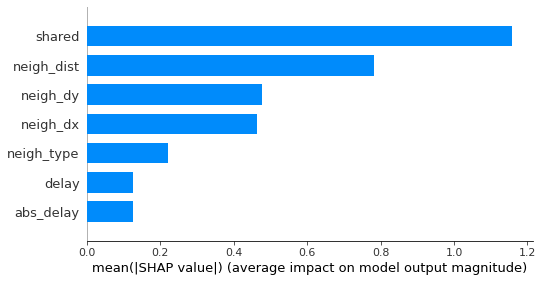

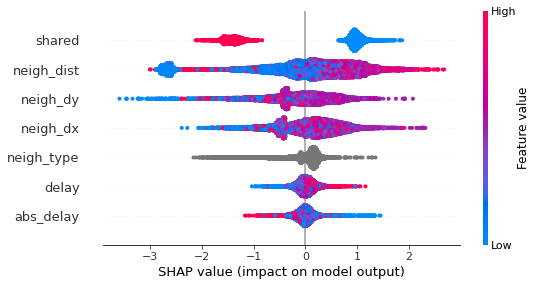

In [16]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(train_pool)

shap.summary_plot(shap_values, train_data[features], plot_type="bar")
shap.summary_plot(shap_values, train_data[features])

In [17]:
model.save_model('proximity_model.cbm')